# Association Rules - Instacart challenge

## Importing librairies

In [77]:
import numpy as np
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load datasets
source: https://www.instacart.com/datasets/grocery-shopping-2017

In [79]:
order_products_prior = pd.read_csv("datasets/instacart_2017_05_01/order_products__prior_light.csv")
order_products_prior.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered
0,0,2,33120,1,1
1,1,2,28985,2,1
2,2,2,9327,3,0
3,3,2,45918,4,1
4,4,2,30035,5,0


In [80]:
products = pd.read_csv("datasets/instacart_2017_05_01/products.csv")
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,38,1
4,5,Green Chile Anytime Sauce,5,13


In [81]:
# join order_product_prior with products using product_id as the key
order_baskets = pd.merge(order_products_prior,products, on=['product_id'], how='inner')

In [82]:
order_baskets.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,0,2,33120,1,1,Organic Egg Whites,86,16
1,237,26,33120,5,0,Organic Egg Whites,86,16
2,1084,120,33120,13,0,Organic Egg Whites,86,16
3,3039,327,33120,5,1,Organic Egg Whites,86,16
4,3709,390,33120,28,1,Organic Egg Whites,86,16


In [83]:
# check the 20 most purchased items
order_baskets['product_name'].value_counts().rename("freq").head(20)

Banana                      321
Bag of Organic Bananas      236
Organic Strawberries        163
Organic Baby Spinach        137
Organic Hass Avocado        129
Organic Avocado             108
Strawberries                 95
Large Lemon                  91
Organic Raspberries          87
Limes                        77
Organic Yellow Onion         72
Organic Whole Milk           70
Organic Garlic               69
Organic Fuji Apple           65
Honeycrisp Apple             62
Organic Blueberries          59
Organic Lemon                55
Cucumber Kirby               54
Organic Half & Half          53
Apple Honeycrisp Organic     53
Name: freq, dtype: int64

In [84]:
# lets look at order_id #2
order_baskets[order_baskets.order_id == 2]

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,0,2,33120,1,1,Organic Egg Whites,86,16
20,1,2,28985,2,1,Michigan Organic Kale,83,4
60,2,2,9327,3,0,Garlic Powder,104,13
63,3,2,45918,4,1,Coconut Butter,19,13
64,4,2,30035,5,0,Natural Sweetener,17,13
65,5,2,17794,6,1,Carrots,83,4
112,6,2,40141,7,1,Original Unflavored Gelatine Mix,105,13
113,7,2,1819,8,1,All Natural No Stir Creamy Almond Butter,88,13
118,8,2,43668,9,0,Classic Blend Cole Slaw,123,4


In [85]:
# lets group orders by order_id and display a list of products in their respective baskets
pd.set_option('max_colwidth', 800)
ob = order_baskets.groupby(['order_id']).product_name.apply(np.array).reset_index()
ob.head()

,order_id,product_name
0,2,"[Organic Egg Whites, Michigan Organic Kale, Garlic Powder, Coconut Butter, Natural Sweetener, Carrots, Original Unflavored Gelatine Mix, All Natural No Stir Creamy Almond Butter, Classic Blend Cole Slaw]"
1,3,"[Total 2% with Strawberry Lowfat Greek Strained Yogurt, Unsweetened Almondmilk, Lemons, Organic Baby Spinach, Unsweetened Chocolate Almond Breeze Almond Milk, Organic Ginger Root, Air Chilled Organic Boneless Skinless Chicken Breasts, Organic Ezekiel 49 Bread Cinnamon Raisin]"
2,4,"[Plain Pre-Sliced Bagels, Honey/Lemon Cough Drops, Chewy 25% Low Sugar Chocolate Chip Granola, Oats & Chocolate Chewy Bars, Kellogg's Nutri-Grain Apple Cinnamon Cereal, Nutri-Grain Soft Baked Strawberry Cereal Breakfast Bars, Kellogg's Nutri-Grain Blueberry Cereal, Tiny Twists Pretzels, Traditional Snack Mix, Goldfish Cheddar Baked Snack Crackers, Original Orange Juice, Sugarfree Energy Drink, Energy Drink]"
3,5,"[Bag of Organic Bananas, Just Crisp, Parmesan, Fresh Fruit Salad, Organic Raspberries, 2% Reduced Fat Milk, Sensitive Toilet Paper, Natural Artesian Water, Mini & Mobile, Matzos, Thin, Tea, Boneless Skinless Chicken Breast Fillets, Mini Original Babybel Cheese, Macaroni And Cheese, Clementines, Biscuits Orange Pim's, Dairy Milk Fruit & Nut Chocolate Bar, Artichokes, Apricot Preserves, One Ply Choose A Size Big Roll Paper Towel Rolls, Wafer, Chocolate, French Lavender Hand Wash, American Slices Cheese, Everyday Facial Tissues, Organic Hass Avocado, Spaghetti Pasta, Meyer Lemon, Bag of Organic Lemons, Original Black Box Tablewater Cracker]"
4,6,"[Cleanse, Dryer Sheets Geranium Scent, Clean Day Lavender Scent Room Freshener Spray]"


## Explore and Transform

In [86]:
# create a sparse matrix representation of our order baskets and create a dataframe of it
te = TransactionEncoder()
products = ob['product_name']
sparse_matrix = te.fit(products).transform(products)
dataset = pd.DataFrame(sparse_matrix, columns=te.columns_)
dataset.head()

,& Go! Hazelnut Spread + Pretzel Sticks,0% Fat Blueberry Greek Yogurt,0% Fat Free Organic Milk,0% Fat Organic Greek Vanilla Yogurt,0% Greek Strained Yogurt,0% Greek Yogurt Black Cherry on the Bottom,0% Milkfat Greek Plain Yogurt,0% Milkfat Greek Yogurt Honey,1 % Lowfat Milk,1 Apple + 1 Mango Fruit Bar,...,Zucchini Noodles,from Concentrate Mango Nectar,gel hand wash sea minerals,in Gravy with Carrots Peas & Corn Mashed Potatoes & Meatloaf Nuggets,of Norwich Original English Mustard Powder Double Superfine,smartwater® Electrolyte Enhanced Water,vitaminwater® XXX Acai Blueberry Pomegranate,with Crispy Almonds Cereal,with Olive Oil Mayonnaise,with Olive Oil Mayonnaise Dressing
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [87]:
te.columns_[:5]

['& Go! Hazelnut Spread + Pretzel Sticks',
 '0% Fat Blueberry Greek Yogurt',
 '0% Fat Free Organic Milk',
 '0% Fat Organic Greek Vanilla Yogurt',
 '0% Greek Strained Yogurt']

## Model and Understand

### Find most frequent itemsets

In [88]:
frequent_itemsets = apriori(dataset, min_support=0.01, use_colnames=True).sort_values(by=['support'], ascending=[False])
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] >= 2)]
frequent_itemsets.head()

,support,itemsets,length
109,0.018710,"(Bag of Organic Bananas, Organic Hass Avocado)",2
116,0.016741,"(Banana, Organic Baby Spinach)",2
118,0.016741,"(Banana, Organic Strawberries)",2
115,0.016741,"(Banana, Organic Avocado)",2
111,0.016248,"(Bag of Organic Bananas, Organic Strawberries)",2


In [89]:
print('Most frequently purchased item sets: {}'.format(list(frequent_itemsets.iloc[0].itemsets)))

Most frequently purchased item sets: ['Bag of Organic Bananas', 'Organic Hass Avocado']


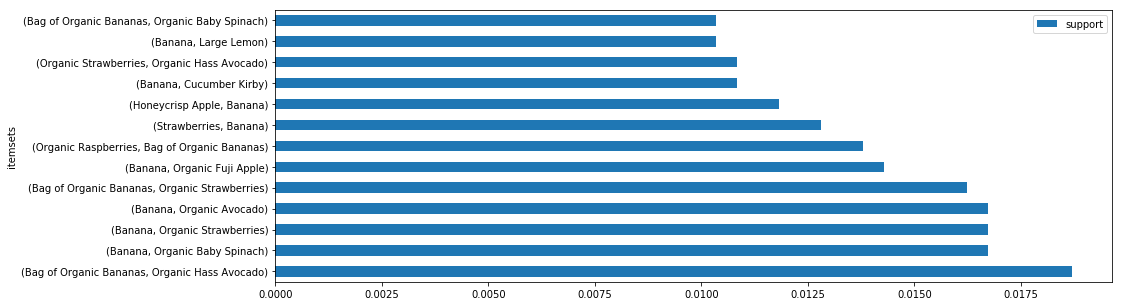

In [90]:
plt.rcParams['figure.figsize'] = [15, 5]
frequent_itemsets.plot.barh(x='itemsets', y='support')
plt.show()

### Create Rules: First set of Association Rules

In [91]:
frequent_itemsets = apriori(dataset, min_support=0.003, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
rules.shape

(71, 9)

In [92]:
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
0,(2% Reduced Fat Milk),(Banana),0.013786,0.158050,0.004431,0.321429,2.033712,0.002252,1.240768,1
1,(Apple Honeycrisp Organic),(Banana),0.026096,0.158050,0.008370,0.320755,2.029448,0.004246,1.239537,1
2,(Frozen Organic Wild Blueberries),(Bag of Organic Bananas),0.013294,0.116199,0.004431,0.333333,2.868644,0.002887,1.325702,1
3,(Organic Creamy Peanut Butter),(Bag of Organic Bananas),0.010832,0.116199,0.003447,0.318182,2.738251,0.002188,1.296242,1
4,(Organic Cucumber),(Bag of Organic Bananas),0.021664,0.116199,0.006893,0.318182,2.738251,0.004376,1.296242,1


In [93]:
rules.sort_values(by=['confidence'], ascending=[False]).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
46,(Strawberry Preserves),(Banana),0.004431,0.158050,0.003447,0.777778,4.921080,0.002746,3.788774,1
65,"(Boneless Skinless Chicken Breasts, Organic Baby Spinach)",(Banana),0.004431,0.158050,0.003447,0.777778,4.921080,0.002746,3.788774,2
55,(Mango Chunks),(Organic Baby Spinach),0.005908,0.067454,0.003447,0.583333,8.647810,0.003048,2.238109,1
70,"(Organic Blackberries, Organic Strawberries)",(Banana),0.006893,0.158050,0.003447,0.500000,3.163551,0.002357,1.683900,2
69,"(Banana, Organic Blackberries)",(Organic Strawberries),0.006893,0.080256,0.003447,0.500000,6.230061,0.002893,1.839488,2
57,(Organic Coconut Milk),(Organic Baby Spinach),0.008370,0.067454,0.003939,0.470588,6.976385,0.003374,1.761475,1
62,"(Organic Raspberries, Organic Hass Avocado)",(Bag of Organic Bananas),0.008370,0.116199,0.003939,0.470588,4.049850,0.002966,1.669402,2
68,"(Organic Zucchini, Organic Baby Spinach)",(Banana),0.007386,0.158050,0.003447,0.466667,2.952648,0.002279,1.578656,2
67,"(Banana, Organic Zucchini)",(Organic Baby Spinach),0.007386,0.067454,0.003447,0.466667,6.918248,0.002948,1.748523,2
7,(Organic Milk),(Bag of Organic Bananas),0.007386,0.116199,0.003447,0.466667,4.016102,0.002588,1.657127,1
